In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import importlib
warnings.filterwarnings('ignore')

In [4]:
sd = "2018-01-01"
ed = "2024-01-01"


snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data_tab = pd.read_html(snp500url)

tickers = data_tab[0][1:]['Symbol'].tolist()


raw = yf.download(tickers=tickers, start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['SOLV', 'SW', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')


In [46]:
df = pd.DataFrame(raw)
missing_frac = df.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.2].index))
df.drop(columns=drop_list, axis = 1, inplace=True)
df.bfill(axis='index', inplace=True)
print('\nNull values:', df.isnull().values.any())
print('NaN values:', df.isna().values.any())


Null values: False
NaN values: False


In [47]:
from sklearn.preprocessing import StandardScaler
returns = df.pct_change().dropna()
returns = pd.DataFrame(returns).reset_index().drop(columns="Date")
scaler = StandardScaler()
normalized_returns = pd.DataFrame(scaler.fit_transform(returns), columns=returns.columns, index=returns.index)

R = normalized_returns.corr().reset_index()

In [48]:

import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px


G = nx.Graph()
G.add_nodes_from(df.columns)
threshold = 0.5
for i in range(len(df.columns)):
    for j in range(i + 1, len(df.columns)):
        corr = R.iloc[i, j]
        if abs(corr) > threshold:
            G.add_edge(df.columns[i], df.columns[j], weight=corr)

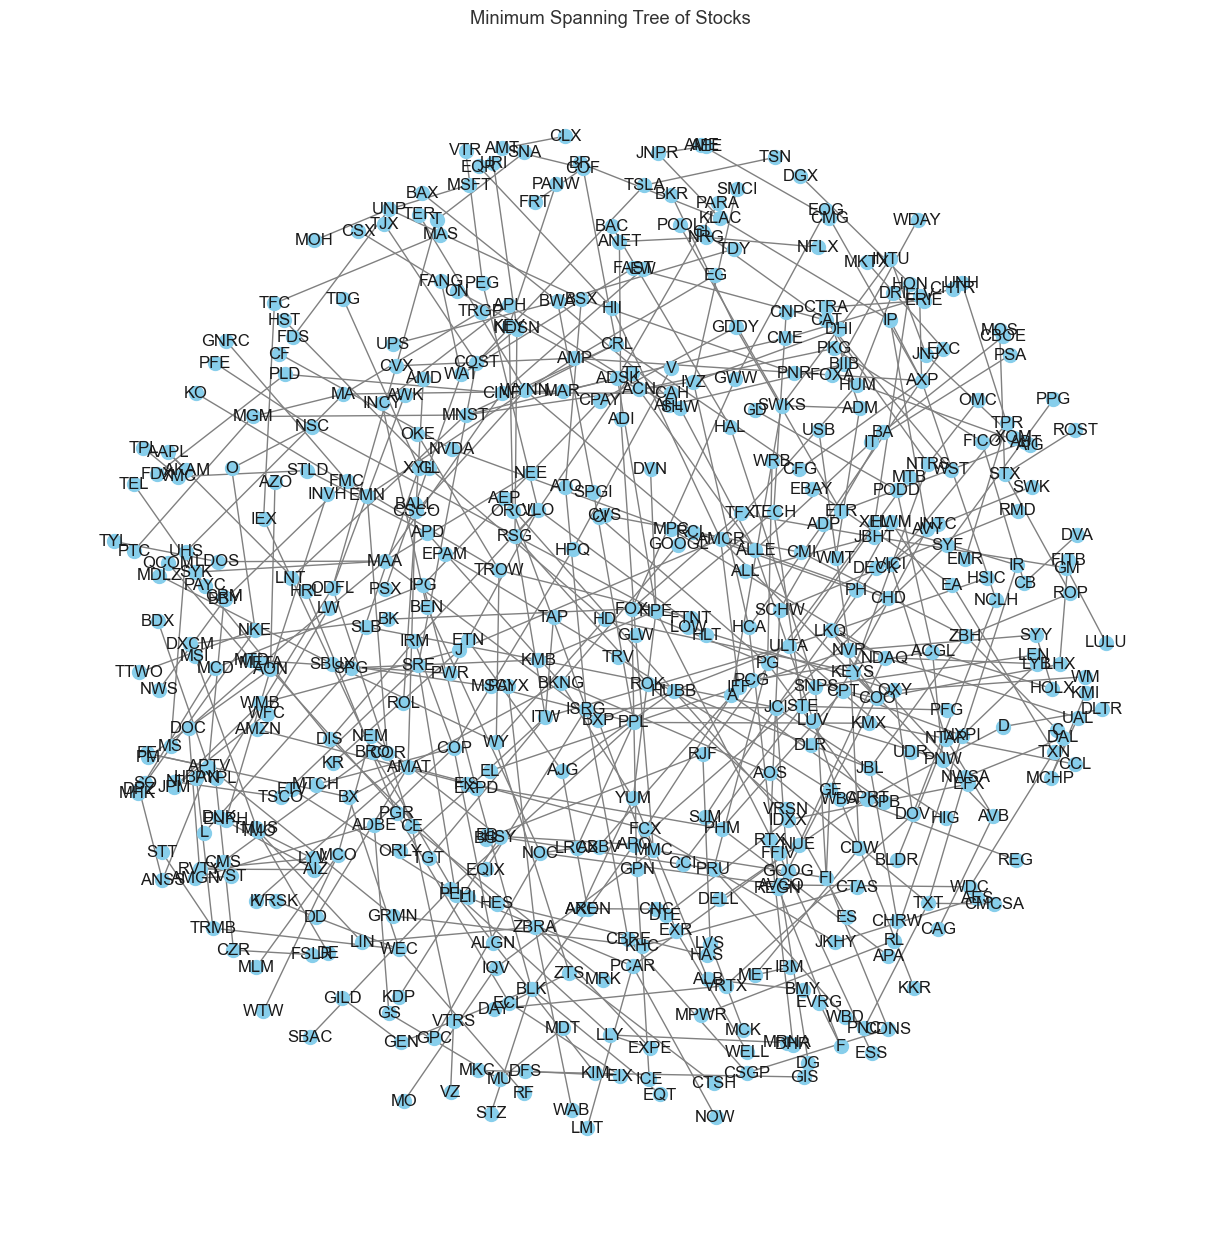

In [ ]:
mst = nx.minimum_spanning_tree(G)

# Plot MST
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(mst, k = 4/np.sqrt(len(df.columns)))
nx.draw(mst, pos, with_labels=True, node_size=100, node_color="skyblue", edge_color="gray")
plt.title("Minimum Spanning Tree of Stocks")
plt.show()

In [50]:
benchmark_data = yf.download("SPY", start=sd, end=ed, auto_adjust=True)['Close']
benchmark_returns = benchmark_data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [51]:
results = pd.DataFrame(columns=['Method', 'Max_d', 'Silhouette Score', 'Cophenetic Correlation', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])

# Clustering evaluation
methods = ['single', 'complete', 'average', 'centroid', 'ward', 'median']
# max_d_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.3, 1.5, 2]
max_d_values= [int(np.arange(3,15)[i]) for i in range(len(np.arange(3,15)))]

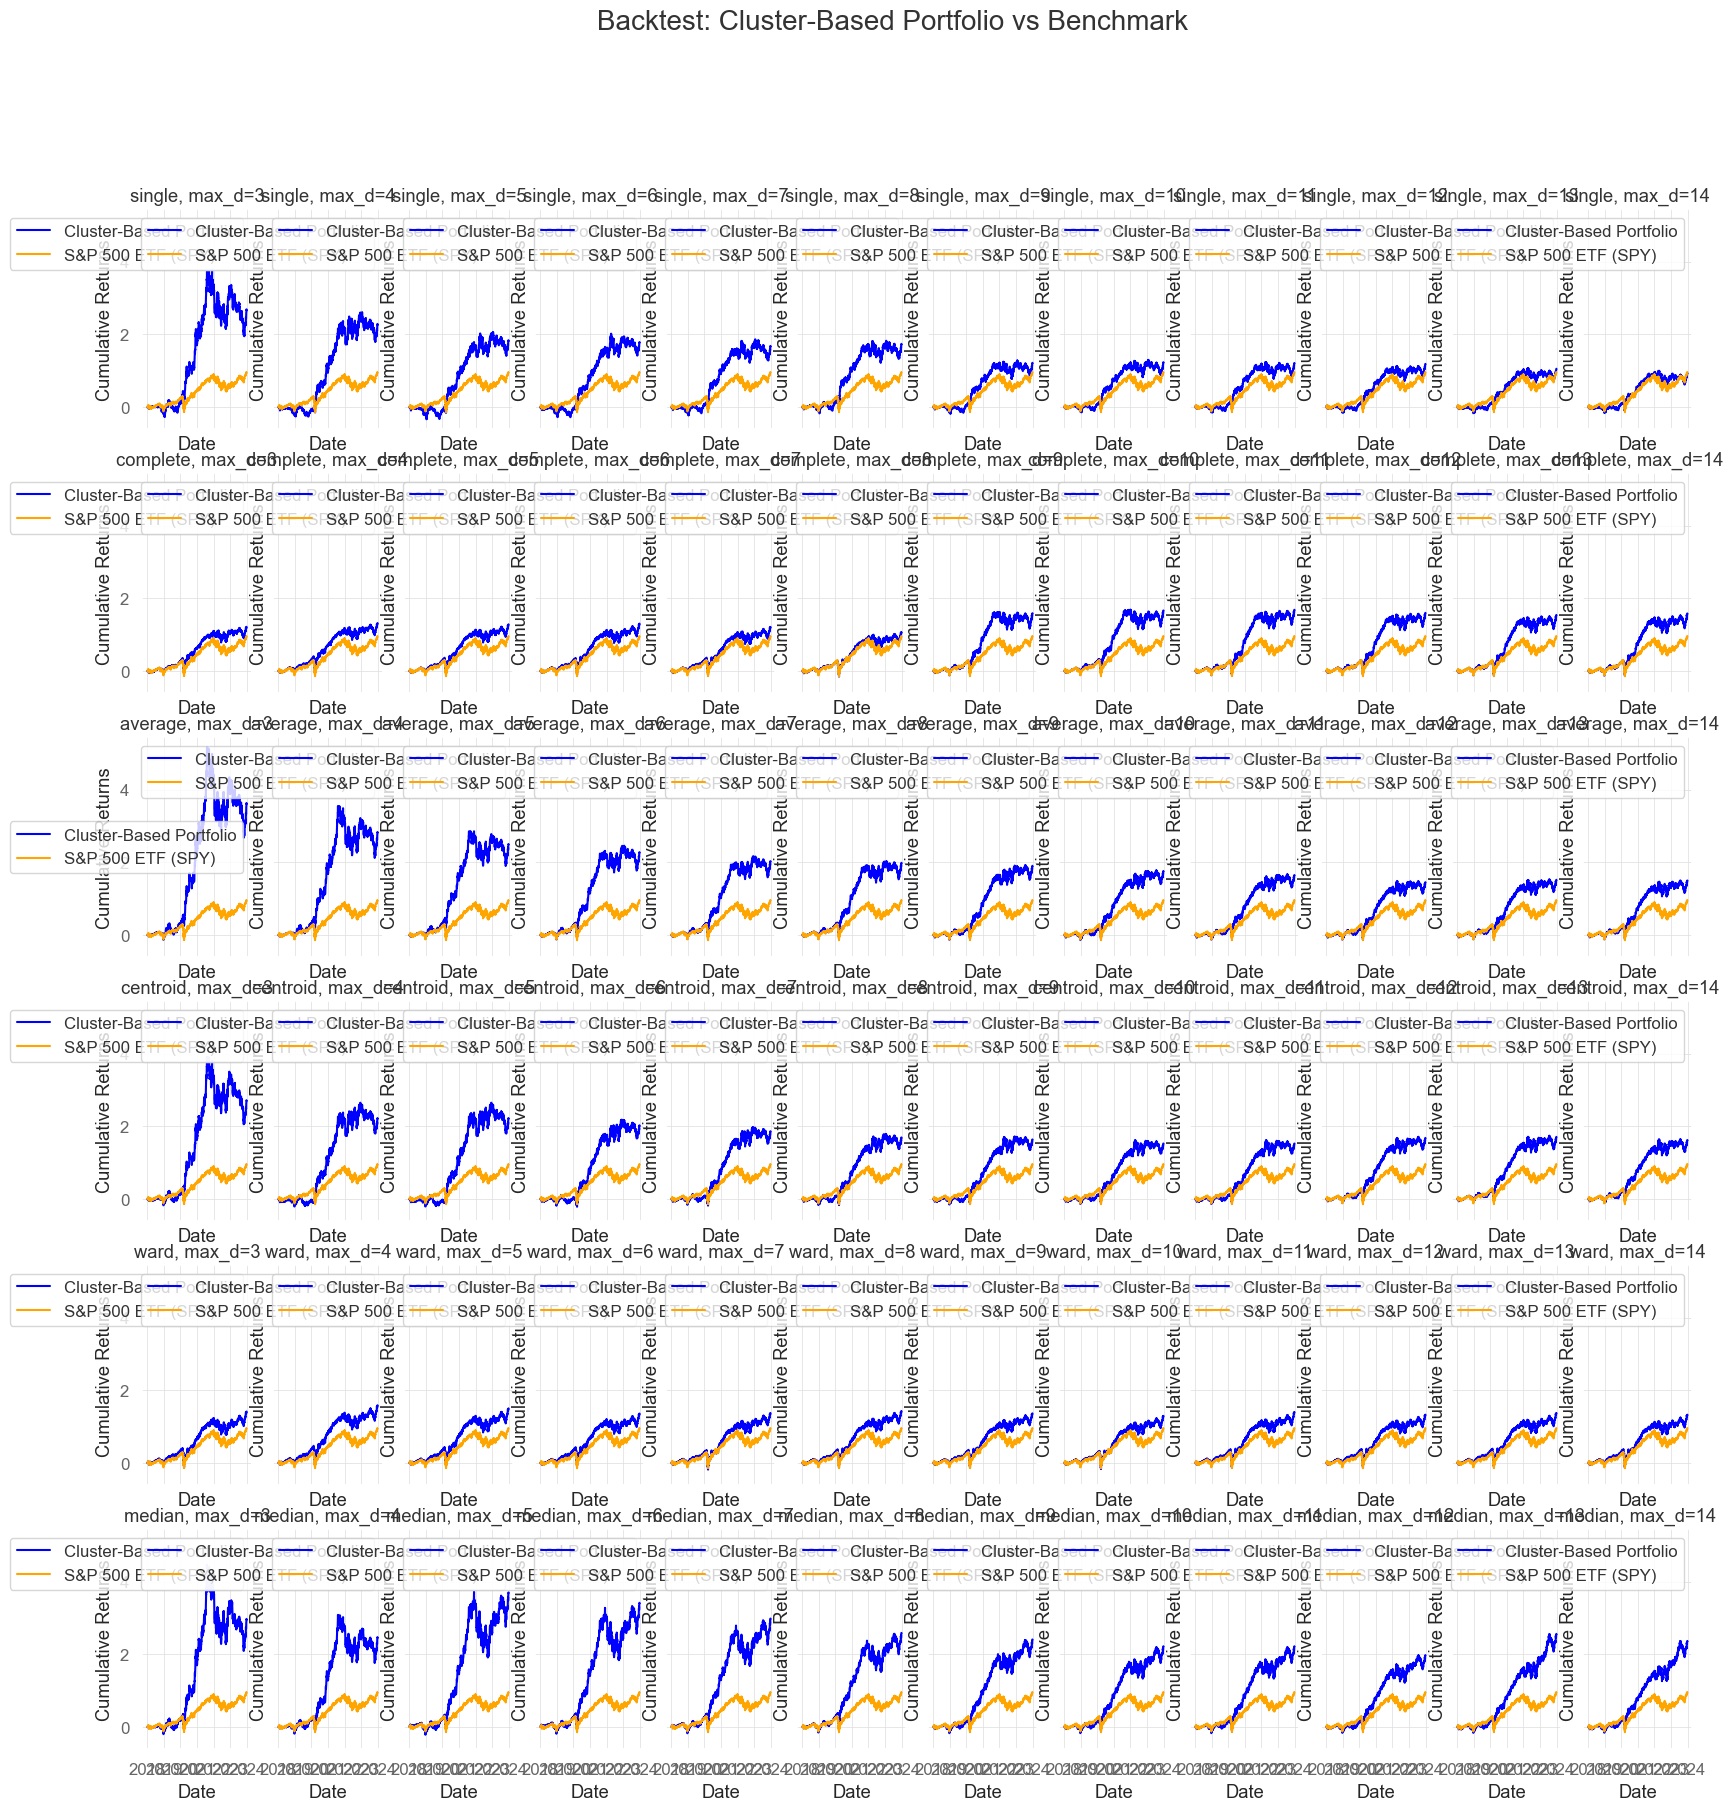

In [52]:
# Prepare subplots
fig, axes = plt.subplots(len(methods), len(max_d_values), figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle("Backtest: Cluster-Based Portfolio vs Benchmark", fontsize=20)

for i, method in enumerate(methods):
    for j, max_d in enumerate(max_d_values):
        distance_matrix = 1 - (R.drop(columns = "Ticker")).abs()
        condensed_distance_matrix = pdist(distance_matrix)
        linkage_matrix = linkage(condensed_distance_matrix, method=method)
        clusters = fcluster(linkage_matrix, max_d, criterion='maxclust')

        # Calculate metrics
        silhouette_avg = silhouette_score(distance_matrix, clusters, metric='precomputed')
        c, _ = cophenet(linkage_matrix, condensed_distance_matrix)
        ch_score = calinski_harabasz_score(normalized_returns.T, clusters)
        db_score = davies_bouldin_score(normalized_returns.T, clusters)

        # Append to results
        result = pd.DataFrame({
            'Method': [method],
            'Max_d': [max_d],
            'Silhouette Score': [silhouette_avg],
            'Cophenetic Correlation': [c],
            'Calinski-Harabasz Score': [ch_score],
            'Davies-Bouldin Score': [db_score]
        })
        results = pd.concat([results, result], ignore_index=True)

        # Cluster-based portfolio
        cluster_returns = []
        unique_clusters = np.unique(clusters)
        for cluster in unique_clusters:
            cluster_stocks = [df.columns[k] for k in range(len(df.columns)) if clusters[k] == cluster]
            cluster_data = returns[cluster_stocks].mean(axis=1)
            cluster_returns.append(cluster_data)

        # Combine cluster returns into a portfolio
        combined_returns = pd.concat(cluster_returns, axis=1).mean(axis=1)
        combined_cum_returns = (1 + combined_returns).cumprod() - 1
        
        benchmark_cum_returns = (1 + benchmark_returns).cumprod() - 1
        # Plot on the respective subplot
        ax = axes[i, j]
        ax.plot(benchmark_cum_returns.reset_index()["Date"], combined_cum_returns, label="Cluster-Based Portfolio", color="blue")
        ax.plot(benchmark_cum_returns.reset_index()["Date"], benchmark_cum_returns.reset_index()["SPY"], label="S&P 500 ETF (SPY)", color="orange")
        ax.set_title(f"{method}, max_d={max_d}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Cumulative Returns")
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [53]:
max_cols = ["Silhouette Score", "Cophenetic Correlation", "Calinski-Harabasz Score"]
min_cols = ["Davies-Bouldin Score"]



# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == normalized_results[col_name].max():
        return max_color
    elif col_name in min_cols and val == normalized_results[col_name].min():
        return min_color
    return ""

# Identify optimal values after normalization
max_silhouette = results["Silhouette Score"].max()
max_cophenetic = results["Cophenetic Correlation"].max()
max_calinski = results["Calinski-Harabasz Score"].max()
min_davies_bouldin = results["Davies-Bouldin Score"].min()

# Filter rows where at least one metric is optimal
optimal_results = results[
    (results["Silhouette Score"] == max_silhouette) |
    (results["Cophenetic Correlation"] == max_cophenetic) |
    (results["Calinski-Harabasz Score"] == max_calinski) |
    (results["Davies-Bouldin Score"] == min_davies_bouldin)
]

normalized_results = optimal_results.copy()
for col in max_cols:
    normalized_results[col] = results[col] / results[col].max()

for col in min_cols:
    normalized_results[col] = results[col].min() / results[col]  # Invert min-based scores for consistency
# Apply styling
styled_results = normalized_results.style.apply(
    lambda x: [highlight_extremes(v, x.name) for v in x], axis=0
)

styled_results

,Method,Max_d,Silhouette Score,Cophenetic Correlation,Calinski-Harabasz Score,Davies-Bouldin Score
0,single,3,1.000000,0.790472,0.081731,0.621087
6,single,9,0.305335,0.790472,0.071949,1.000000
12,complete,3,0.502692,1.000000,0.630098,0.219582
13,complete,4,0.480968,1.000000,0.604776,0.227590
14,complete,5,0.119098,1.000000,0.590593,0.203641
15,complete,6,0.184050,1.000000,0.632394,0.194877
16,complete,7,0.088385,1.000000,0.555972,0.196103
17,complete,8,0.096616,1.000000,0.499059,0.204774
18,complete,9,0.098869,1.000000,0.447943,0.225238
19,complete,10,0.055130,1.000000,0.425217,0.225314


In [54]:
normalized_results["final"] = normalized_results["Silhouette Score"]+normalized_results["Calinski-Harabasz Score"]+normalized_results["Cophenetic Correlation"]-normalized_results["Davies-Bouldin Score"]
normalized_results                

,Method,Max_d,Silhouette Score,Cophenetic Correlation,Calinski-Harabasz Score,Davies-Bouldin Score,final
0,single,3,1.000000,0.790472,0.081731,0.621087,1.251115
6,single,9,0.305335,0.790472,0.071949,1.000000,0.167755
12,complete,3,0.502692,1.000000,0.630098,0.219582,1.913208
13,complete,4,0.480968,1.000000,0.604776,0.227590,1.858154
14,complete,5,0.119098,1.000000,0.590593,0.203641,1.506050
15,complete,6,0.184050,1.000000,0.632394,0.194877,1.621567
16,complete,7,0.088385,1.000000,0.555972,0.196103,1.448254
17,complete,8,0.096616,1.000000,0.499059,0.204774,1.390901
18,complete,9,0.098869,1.000000,0.447943,0.225238,1.321573
19,complete,10,0.055130,1.000000,0.425217,0.225314,1.255033


In [63]:
distance_matrix = 1 - (R.drop(columns = "Ticker")).abs()
condensed_distance_matrix = pdist(distance_matrix)
linkage_matrix = linkage(condensed_distance_matrix, method="complete")
clusters = fcluster(linkage_matrix, 3, criterion='maxclust')

In [60]:
import importlib
import analysis.data.dataframe_creation as dataframe_creation
importlib.reload(dataframe_creation)
from analysis.data.dataframe_creation import pipeline
sd = "2018-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)

[*********************100%***********************]  1 of 1 completed
[                       0%                       ]  2 of 502 completed

Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['SOLV', 'SW', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')



Null values: False
NaN values: False

Creating features
The dataset has 485 assets
The dataset has 16 predictors:
Ticker
Yavg_return
Yavg_volatility
beta
mkt_corr
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry


Dataset creation finished



In [64]:
final_dataframe = dataset[dataset["Ticker"].isin(returns.columns)]
final_dataframe["Sector"] = clusters

cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]

max_cols = ["beta", "D_eSkewness", "Yavg_return", "Sharpe_ratio", "Davg_volume"]
min_cols = ["beta", "Davg_span", "D_eCurtosis", "Yavg_volatility", "D_eVaR", "D_eCVaR", 
            "totalEsg", "environmentScore", "socialScore", "governanceScore"]

# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == cluster_profile[col_name].max():
        return max_color
    elif col_name in min_cols and val == cluster_profile[col_name].min():
        return min_color
    return ""

cluster_profile.style.apply(lambda x: [highlight_extremes(v, x.name) for v in x], axis=0)

,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,Count
Sector,,,,,,,,,,,,,,,,
1,0.123031,0.344472,0.493234,0.300713,3.157173,4361132.669939,0.344736,-0.000811,-0.001532,19.518197,0.299098,23.782500,7.868125,11.483750,4.432500,16
2,0.170176,0.357055,1.131410,0.653837,3.431307,6265518.289864,-0.063898,-0.000623,-0.000982,11.403158,0.420597,20.254817,5.797012,8.689756,5.767805,331
3,0.152126,0.310551,0.785571,0.521607,3.052330,6444066.105320,-0.186920,-0.000564,-0.000903,12.770117,0.425455,20.472847,5.581985,9.631176,5.259853,138


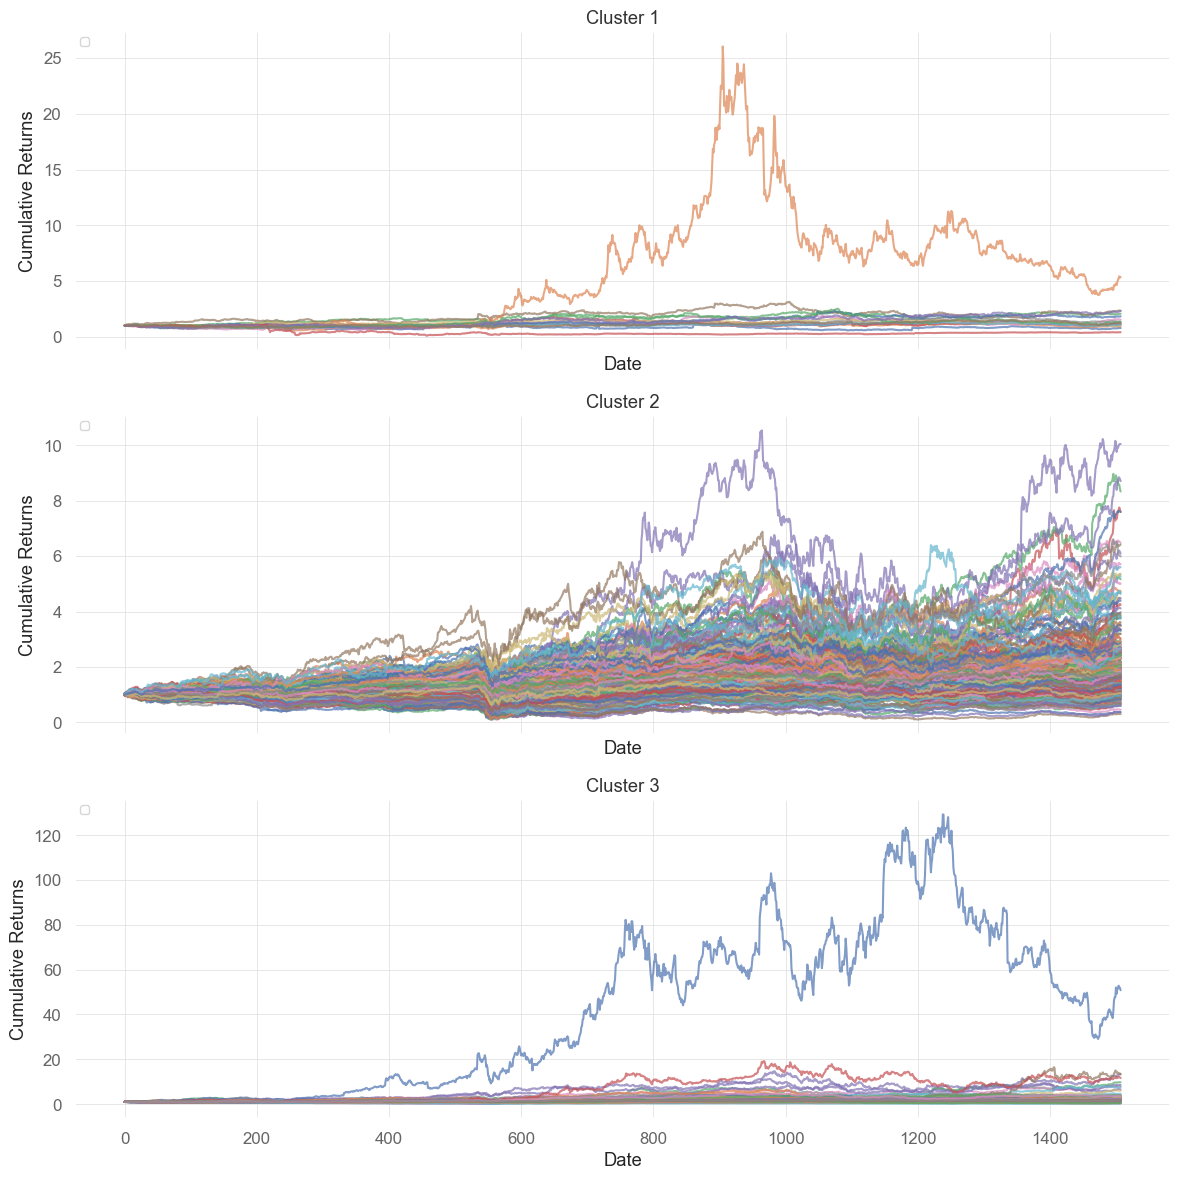

In [65]:
clusters_df = pd.DataFrame({'Ticker': returns.columns, 'Cluster': clusters})

# Identify unique clusters
unique_clusters = np.unique(clusters)

num_clusters = len(unique_clusters)

# Prepare subplots
fig, axes = plt.subplots(num_clusters, 1, figsize=(12, 4 * num_clusters), sharex=True)

if num_clusters == 1:  # Ensure axes is iterable for a single cluster case
    axes = [axes]

# Plot return evolution for each cluster
for i, cluster in enumerate(unique_clusters):
    ax = axes[i]
    
    # Select tickers belonging to this cluster
    cluster_tickers = clusters_df[clusters_df["Cluster"] == cluster]["Ticker"].values

    # Compute cumulative returns for each stock
    for ticker in cluster_tickers:
        cumulative_returns = (1 + returns[ticker]).cumprod()
        ax.plot(returns.index, cumulative_returns, alpha=0.7)

    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Returns")
    ax.legend(fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

In [66]:
from analysis.data.dataframe_creation import create_portfolio_clustered
sd_test = ed
ed_test = "2025-01-10"
portfolio_ret_t, asset_ret_t = create_portfolio_clustered(sd_test, ed_test, final_dataframe, list(final_dataframe["Ticker"]), w="uniform")

[*********************100%***********************]  485 of 485 completed


Null values: False
Null values: False


In [67]:
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-03-14   2024-03-14
End Period                 2025-01-08   2025-01-08
Risk-Free Rate             2.0%         2.0%
Time in Market             100.0%       100.0%

Cumulative Return          3.45%        8.92%
CAGR﹪                     2.89%        7.44%

Sharpe                     0.22         0.83
Prob. Sharpe Ratio         51.73%       73.16%
Smart Sharpe               0.2          0.74
Sortino                    0.3          1.18
Smart Sortino              0.27         1.05
Sortino/√2                 0.21         0.83
Smart Sortino/√2           0.19         0.74
Omega                      1.14         1.14

Max Drawdown               -12.14%      -6.99%
Longest DD Days            107          101
Volatility (ann.)          13.96%       10.9%
R^2                        0.14         0.14
Information Ratio          0.03         0.03
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-12-02,2024-12-19,2025-01-08,38,-6.993627,-6.535274
2,2024-04-01,2024-04-17,2024-07-10,101,-5.665384,-5.637418
3,2024-08-01,2024-08-05,2024-08-14,14,-4.252861,-3.911220
4,2024-10-21,2024-11-01,2024-11-05,16,-2.847944,-2.783377
5,2024-09-03,2024-09-06,2024-09-13,11,-2.813198,-1.864757


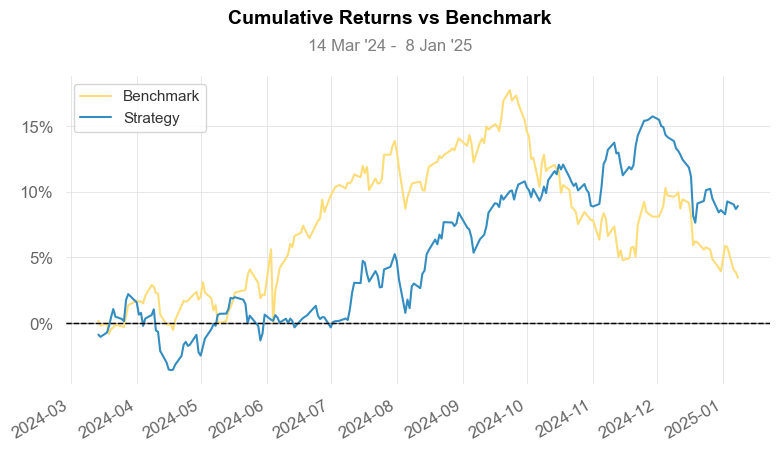

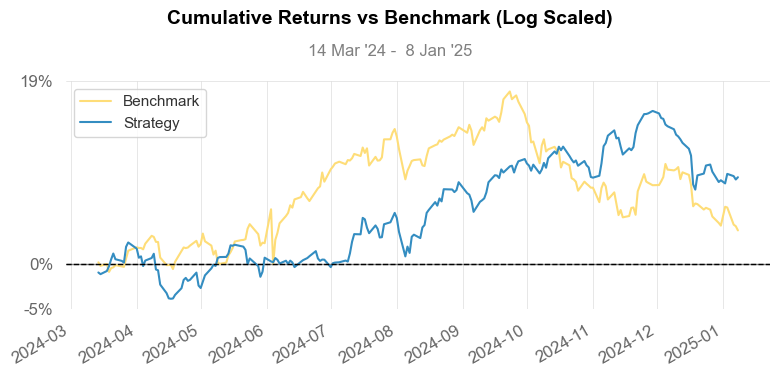

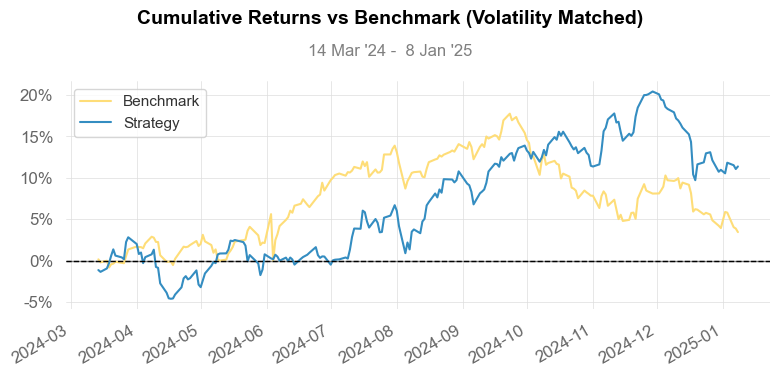

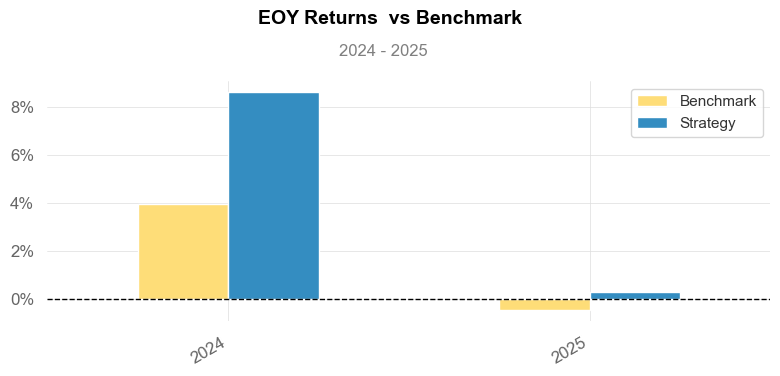

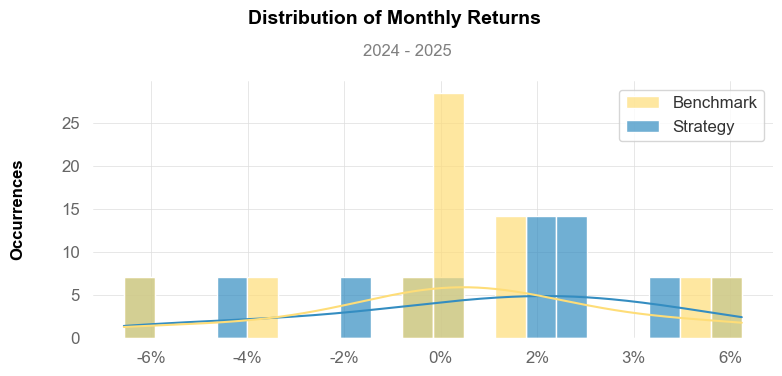

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [71]:
import quantstats as qs
def weights(ratios, cluster, pow, thresh):
    w = np.array(ratios["Sharpe_ratio"] > thresh)*ratios["Sharpe_ratio"]
    ratios["weights"] = np.power(w, pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]


rets = np.zeros(len(portfolio_ret_t))
cp = cluster_profile.reset_index()
for i in portfolio_ret_t.columns:
        weight = weights(cp[["Sector", "Sharpe_ratio"]], i, 1, 0.3).values[0]
        rets += weight*portfolio_ret_t[i] 
portfolio_performance = pd.DataFrame(rets).reset_index()

portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]
# Run the QuantStats full report
qs.reports.full(portfolio_performance["Returns"], benchmark="NDIA", rf=0.02)